In [165]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import neighbors
from sklearn.cluster import KMeans
from pycaret.clustering import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA,TruncatedSVD
import sklearn_recommender as skr

In [59]:
data = pd.read_csv('data/people_search.csv')

In [60]:
data.columns

Index(['Employee ID', 'Name', 'Gender', 'Role', 'Grade', 'Hire Date',
       'Home Office', 'Current Working Office', 'Staffing Office',
       'Total Years of EXP', 'TW Years of EXP', 'Skills'],
      dtype='object')

In [61]:
data.Role.describe()

count           308
unique           27
top       Developer
freq            171
Name: Role, dtype: object

In [62]:
data.Grade.describe()

count                   308
unique                   10
top       Senior Consultant
freq                    117
Name: Grade, dtype: object

In [63]:
data.Gender.describe()

count     308
unique      3
top       Man
freq      199
Name: Gender, dtype: object

In [64]:
data.Skills

0      [Expert]: Tamil;\n[Experienced]: Docker,Go CD,...
1      [Experienced]: English,Hindi;\n[Moderate]: C++...
2      [Expert]: Presenting,Teaching,English,Tamil;\n...
3                                                    NaN
4      [Expert]: Defect management,Manual/Exploratory...
                             ...                        
303                                                  NaN
304    [Experienced]: React,React Native,Redux ,Respo...
305    [Expert]: Tamil;\n[Experienced]: CSS,Feedback ...
306    [Experienced]: Defect management,Manual/Explor...
307                                                  NaN
Name: Skills, Length: 308, dtype: object

In [65]:
data.Skills.apply(lambda x:str(x).replace("[Expert]: ","").replace(";\n",",").replace("[Experienced]: ",""))

0      Tamil,Docker,Go CD,Golang,Java,Javascript,Node...
1      English,Hindi,[Moderate]: C++,HTML,Manual/Expl...
2      Presenting,Teaching,English,Tamil,ElasticSearc...
3                                                    nan
4      Defect management,Manual/Exploratory Testing,J...
                             ...                        
303                                                  nan
304    React,React Native,Redux ,Responsive Web Desig...
305    Tamil,CSS,Feedback & Coaching,English,[Moderat...
306    Defect management,Manual/Exploratory Testing,R...
307                                                  nan
Name: Skills, Length: 308, dtype: object

In [66]:
def return_column(skills_input,level):
    skill = list()
    skills = skills_input.replace(";\n","#$")
    if f"[{level}]: " in skills:
        replace_str = f"[{level}]: "
        curr_str_index = skills.find(replace_str)
        curr_end_index = skills.find("#$",curr_str_index)
        if curr_end_index == -1:
            skill.extend(skills[curr_str_index].replace(replace_str,"").split(","))
        else:
            skill.extend(skills[curr_str_index:curr_end_index].replace(replace_str,"").split(","))
    return skill

In [67]:
all_skills = []
for index, row in data.iterrows():
    skill_row = str(row['Skills'])
    all_skills.extend(return_column(skill_row,'Expert'))
    all_skills.extend(return_column(skill_row,'Moderate'))        
    all_skills.extend(return_column(skill_row,'Beginner'))        
    all_skills.extend(return_column(skill_row,'Experienced'))        
    all_skills.extend(return_column(skill_row,'Want to learn'))        

In [68]:
all_skills = list(set(all_skills))
all_skills.remove('[')

In [69]:
len(all_skills)

259

In [70]:
all_skills

['AppDynamics',
 'PHP',
 'R',
 'React',
 'Postgres',
 'Healthcare',
 'JMeter ',
 'Software & Internet',
 'CircleCI ',
 'Ionic',
 'Presenting',
 'Statistical Modeling',
 'Ruby on Rails',
 'Communication',
 'Mobile Development (Android / iOS / PhoneGap)',
 'Appium',
 'SASS/SCSS',
 'Usability Research',
 'Backend for Frontend',
 'Iteration Management',
 'Large-scale data processing',
 'Portuguese',
 'Design Patterns ',
 'Inception',
 'Manufacturing',
 'Maven',
 'Jenkins',
 'Business Services',
 'System thinking',
 'GraphQL',
 'Terraform',
 'Python',
 'Bootstrap ',
 'iOS',
 'Arduino',
 'Couch DB',
 'Lambda ',
 'React Native',
 'Search Engine Optimization',
 'JQuery ',
 'Ruby application development',
 'User Research & Customer Analysis',
 'Gatling ',
 'Teaching',
 'Cucumber',
 'Transportation & Storage',
 'Redux ',
 'Wholesale & Distribution',
 'Selenium-webdriver',
 'Java test automation',
 'Data Center applications',
 'Elixir ',
 'Riak',
 'Security testing',
 'Azure ',
 'Manual/Explorato

In [71]:
skills_df = pd.DataFrame(np.zeros((data.shape[0],len(all_skills))),columns=all_skills)

In [72]:
people_skills = pd.concat([data,skills_df],axis=1)

In [73]:
def add_skill(row,skill_name,skill_level,skill_cols):
    skill_row = str(row['Skills'])
    skill_person = return_column(skill_row,skill_name)
    for skill in skill_person:
        if skill in skill_cols:
            row[skill] = skill_level
    return row

In [74]:
people_skills_map = people_skills.apply(lambda x: add_skill(x,'Expert',4,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Experienced',3,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Moderate',2,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Beginner',1,people_skills.columns),axis=1)

In [75]:
people_data = people_skills_map.drop(columns=['Home Office','Current Working Office','Staffing Office','Skills','Name','Hire Date'])

In [76]:
people_data.columns

Index(['Employee ID', 'Gender', 'Role', 'Grade', 'Total Years of EXP',
       'TW Years of EXP', 'AppDynamics', 'PHP', 'R', 'React',
       ...
       'Storytelling & Storyboarding', 'Synthesis', 'Strategy',
       'Machine Learning', 'C# application development', 'Less', 'Jade',
       'Webpack', 'Tamil', 'Performance testing'],
      dtype='object', length=265)

In [77]:
setup(people_data,normalize=True, normalize_method='minmax',pca=True,pca_components=0.7)

Setup Succesfully Completed!


,Description,Value
0,session_id,1877
1,Original Data,"(308, 265)"
2,Missing Values,False
3,Numeric Features,244
4,Categorical Features,21
5,Ordinal Features,False
6,High Cardinality Features,False
7,Transformed Data,"(308, 31)"
8,Numeric Imputer,mean
9,Categorical Imputer,constant


(     Component_1  Component_2  Component_3  Component_4  Component_5  \
 0       0.017874    -0.499913     0.123025     0.998282    -0.431020   
 1      -0.037549     1.459047     0.574254     0.770839     0.426928   
 2       0.918760    -0.042799    -1.334854     1.206642     0.311673   
 3      -1.500802     0.058704     0.160101    -0.720927    -0.055236   
 4       0.143833     1.264119     2.107825     1.074510     0.593716   
 ..           ...          ...          ...          ...          ...   
 303    -1.509756    -0.067859    -0.026176    -0.503800     0.581128   
 304     1.402227    -0.347906    -1.210256     1.153735    -0.024850   
 305     0.384642    -0.019196    -0.712961     1.258683     0.269248   
 306     0.125852     1.670500    -0.150047    -0.581553     0.689541   
 307    -1.604600     0.007445     0.092072    -0.740134     0.036798   
 
      Component_6  Component_7  Component_8  Component_9  Component_10  ...  \
 0      -0.905779    -0.417854    -0.274192

In [78]:
model = create_model('kmeans',num_clusters=5)

,Metric
Silhouette,0.1487
Calinski-Harabasz,36.3987
Davies-Bouldin,2.0094


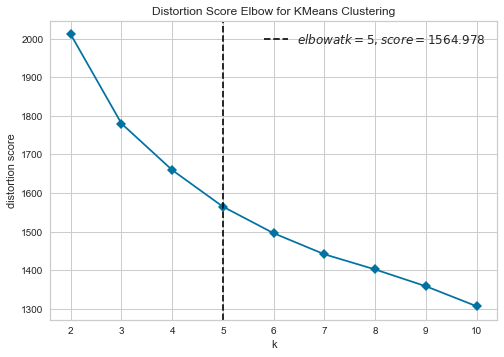

In [79]:
plot_model(model,plot='elbow') 

In [80]:
plot_model(model,plot='distribution') 

In [81]:
plot_model(model,plot='tsne') 

In [82]:
predictions = predict_model(model, data = people_data)

In [83]:
def get_match(emp_id):
    joined = pd.merge(data, predictions)
    cluster = joined[joined['Employee ID'] == emp_id]['Cluster'].values[0]
    return joined[joined['Cluster'] == cluster]['Name']

In [84]:
get_match(21824)

34                Balaji Arumugam
35               Balaji Sivakumar
36               Balaji Sivaraman
38           Balanagammal Murugan
41            Bharani Subramaniam
54                Clement Lloyd P
59         Dharanikumar Premkumar
62                 Dinesh Kumar S
73         Ginette Thomas Vellera
74            Gobinath Thangavelu
79         Guruprasad Subramanian
90                Jagdsh LK Chand
91                   Jahan Arun J
111                     Kavitha R
146      Muralidharan Nandhakumar
165              Nithya Sivakumar
192                 Rajagopal P S
218                    Saranraj S
229              Shakir A Shakiel
230          Shankar Ramakrishnan
244           Sooraj Parameswaran
258             Sriram Narasimhan
296    Vijay Raghavan Aravamudhan
298                 Vijayakumar G
299               Vijayaragavan G
300           Vikhyath Choradia N
Name: Name, dtype: object

In [126]:
people_processed = pd.get_dummies(people_data)

In [127]:
people_processed

,Employee ID,Total Years of EXP,TW Years of EXP,AppDynamics,PHP,R,React,Postgres,Healthcare,JMeter,...,Grade_Associate,Grade_Consultant,Grade_Consultant - Graduate,Grade_Intern,Grade_Lead Associate,Grade_Lead Consultant,Grade_Principal Associate,Grade_Principal Consultant,Grade_Senior Associate,Grade_Senior Consultant
0,17605,5.25,5.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,15622,6.96,6.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,24229,3.14,1.44,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,23987,8.52,1.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,13506,12.65,9.85,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,24582,3.34,1.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
304,28194,0.06,0.06,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
305,22672,2.14,2.14,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0,1,0,0,0,0,0,0,0,0
306,26741,7.99,0.69,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
# kmeans = KMeans(n_clusters=12)
# kmeans.fit(people_processed)
# kmeans.cluster_centers_

,Employee ID,Total Years of EXP,TW Years of EXP,AppDynamics,PHP,R,React,Postgres,Healthcare,JMeter,...,Grade_Associate,Grade_Consultant,Grade_Consultant - Graduate,Grade_Intern,Grade_Lead Associate,Grade_Lead Consultant,Grade_Principal Associate,Grade_Principal Consultant,Grade_Senior Associate,Grade_Senior Consultant
192,21824,11.49,2.59,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [137]:
employee = people_processed[people_processed['Employee ID']==21824]
cosine =cosine_similarity(employee,people_processed)
cosine

array([[0.99999958, 0.99999951, 0.9999996 , 0.99999958, 0.99999889,
        0.99999945, 0.99999964, 0.99999951, 0.99999952, 0.99999951,
        0.99999963, 0.99999952, 0.99999956, 0.99999964, 0.99999959,
        0.99999934, 0.99999959, 0.99999934, 0.99999962, 0.99999879,
        0.99999945, 0.99999957, 0.99999963, 0.99999954, 0.99999963,
        0.99999958, 0.9999993 , 0.99999956, 0.99999958, 0.99999959,
        0.99999958, 0.99999951, 0.99999945, 0.99999952, 0.9999996 ,
        0.99999971, 0.99999949, 0.99999945, 0.99999956, 0.99999947,
        0.99999967, 0.99999865, 0.9999996 , 0.9999996 , 0.99999927,
        0.99999962, 0.99999971, 0.99999894, 0.99999945, 0.99999921,
        0.99999962, 0.99999931, 0.99999945, 0.99999866, 0.99999958,
        0.99999898, 0.99999897, 0.99999937, 0.99999945, 0.9999996 ,
        0.99999875, 0.99999952, 0.99999937, 0.99999961, 0.99999899,
        0.99999955, 0.99999949, 0.99999955, 0.99999945, 0.99999959,
        0.99999884, 0.99999951, 0.99999961, 0.99

In [155]:
tf = skr.transformer.SimilarityTransformer(cols=(1, -1), index_col='Employee ID', normalize=True)
sim_mat = tf.transform(people_processed)
def recommend(emp_id,n_records=10):
    rec = skr.recommender.SimilarityRecommender(n_records)
    rec.fit(sim_mat)
    predictions = rec.predict([emp_id])
    print(data[data['Employee ID'].isin(predictions[0])]['Name'])

In [183]:
recommend(21824,5)

47     Boojapathy Chidambaram
55         Deepak Paramasivam
73     Ginette Thomas Vellera
94                Jayakumar C
133              Manikandan S
Name: Name, dtype: object


In [182]:
people_wo_id= people_processed.loc[:,people_processed.columns != 'Employee ID']
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(people_wo_id)
svd.explained_variance_ratio_.sum()

0.9644715348565802